In [1]:
!pip install imblearn

In [2]:
import imblearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [5]:
diabetes=pd.read_csv('diabetes.csv')
#diabetes.head()
diabetes.Outcome.value_counts(dropna=False)

0    500
1    268
Name: Outcome, dtype: int64

# Assumptions of Logistic Reg

## No collinearity

In [6]:
# X/y split
X = diabetes.drop('Outcome',axis = 1)
y = diabetes['Outcome']

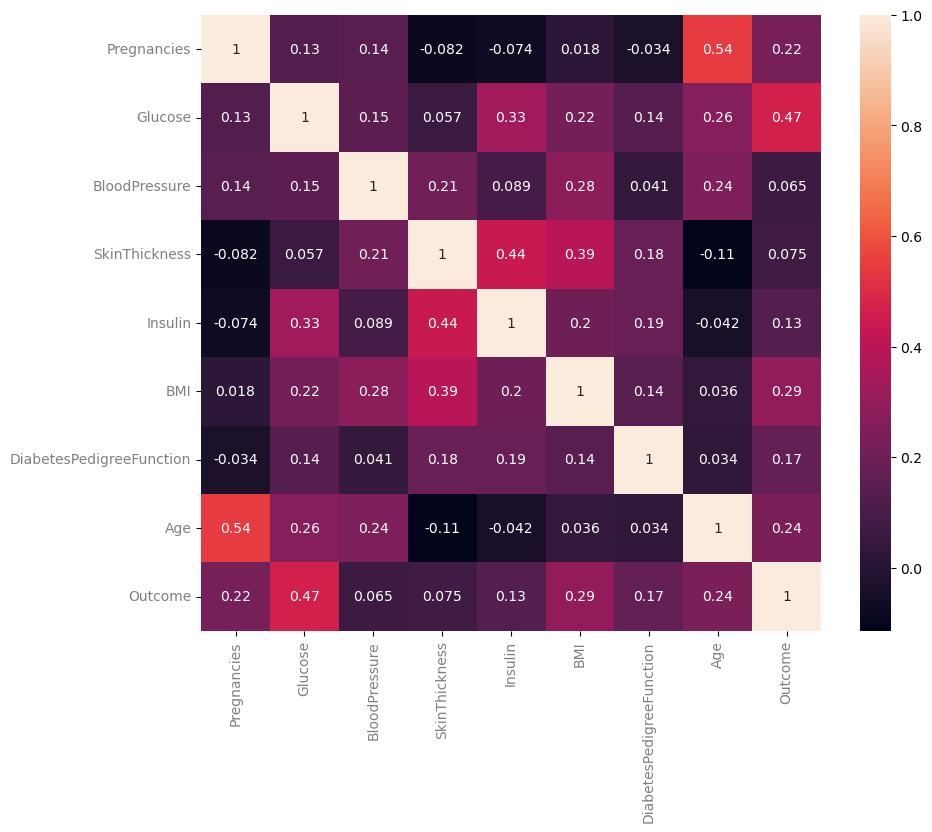

In [7]:
correlations_matrix = diabetes.corr()
fig, ax = plt.subplots(figsize=(10, 8))
g = sns.heatmap(correlations_matrix, annot=True)
for tick_label in g.axes.get_yticklabels():
    tick_label.set_color("grey")
    tick_label.set_fontsize("10")
for tick_label in g.axes.get_xticklabels():
    tick_label.set_color("grey")
    tick_label.set_fontsize("10")
plt.show()

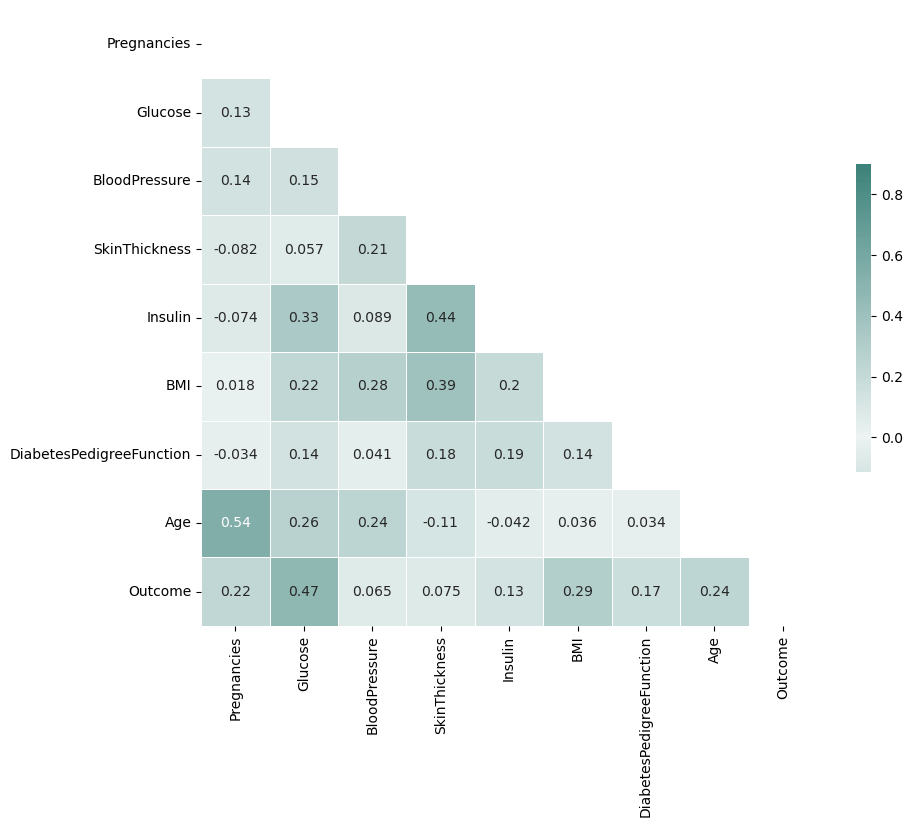

In [8]:
mask = np.zeros_like(correlations_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Want diagonal elements as well?
# mask[np.diag_indices_from(mask)] = False

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(180, 180, as_cmap=True)
# https://www.learnui.design/blog/the-hsb-color-system-practicioners-primer.html

# Draw the heatmap with the mask and correct aspect ratio
sns_plot = sns.heatmap(correlations_matrix, mask=mask, cmap=cmap, vmax=.9, center=0,
        square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
# save to file
fig = sns_plot.get_figure()
fig.savefig("features_heatmap.png")

## Standardization of independent variables

In [9]:
# here we start scaling, so need to do train-test-split before
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0) # default fraction is test_size = 0.25 

In [10]:
# all features are numeric, so no need to split into _num and _cat
scaler = StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train),columns=X.columns)

# we can immediately transform the X_test as well
X_test_scaled = pd.DataFrame(scaler.transform(X_test),columns=X.columns)
X_train_scaled.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,1.507552,-1.015215,-0.404519,-1.319215,-0.718238,-1.220701,-0.983259,-0.048640
1,-0.829864,-0.099647,-0.615096,0.928730,0.083747,0.137191,-0.624936,-0.882466
2,-1.122041,-0.952072,0.543076,-1.319215,-0.718238,0.024033,0.398842,-0.548935
3,2.384083,0.594922,0.648364,1.365830,2.054583,0.879002,0.179030,2.035925
4,1.507552,0.752778,0.543076,1.553159,0.390891,0.715552,0.507242,0.535038


In [11]:
# needed because the transformation also reset the index for X_train_scaled
# so we need this for y_test as well...
y_train = y_train.reset_index(drop=True) 
y_test = y_test.reset_index(drop=True)

# Imbalance and metrics

<Axes: >

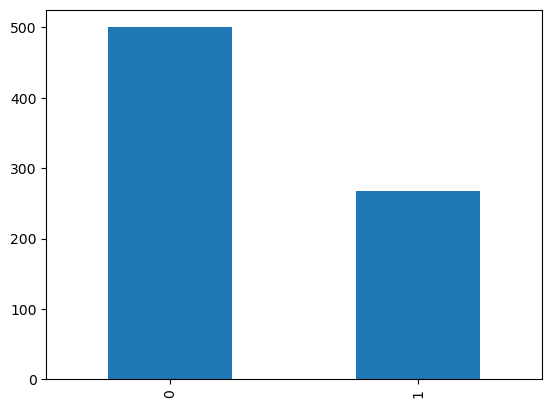

In [12]:
# while there are more imbalanced datasets, we have a significant imbalance
# and the cost of failing to detect the minority class is quite high (lack of diagnosis of diabetes)
count_classes = diabetes['Outcome'].value_counts()
count_classes.plot(kind = 'bar')

# A relatively bad model

In [13]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(random_state=0, solver='lbfgs')
LR.fit(X_train_scaled, y_train)
LR.score(X_test_scaled, y_test)

0.8020833333333334

In [14]:
# What does this number mean??
# Discuss precision and recall

In [15]:
#while accuracy is not absolutely terrible, a closer look reveals some serious problems
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

pred = LR.predict(X_test_scaled)

print("precision: ",precision_score(y_test,pred))
print("recall: ",recall_score(y_test,pred))
print("f1: ",f1_score(y_test,pred))

precision:  0.75
recall:  0.5806451612903226
f1:  0.6545454545454547


In [16]:
#we fail to identify 40%+ of diabetes cases!
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred)   # target then prediction!

array([[118,  12],
       [ 26,  36]])

In [17]:
confusion_matrix(y_test, pred)[1][0]

26

In [21]:
def evaluate_model(note, model, X_test, y_test, results):
    pred = model.predict(X_test)
    score = model.score(X_test, y_test)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    false_negatives = confusion_matrix(y_test, pred)[1][0]
    new_result = pd.DataFrame({'note':note,'accuracy':score,'precision':precision,'recall':recall,'f1_score':f1,'false_negatives':false_negatives},index=[0])
    return pd.concat([results,new_result],axis=0)

results = pd.DataFrame(columns=['note','accuracy','precision','recall','f1_score', 'false_negatives'])

In [22]:
results

,note,accuracy,precision,recall,f1_score,false_negatives


In [23]:
results = evaluate_model('Before sampling', LR, X_test_scaled, y_test, results)
results

,note,accuracy,precision,recall,f1_score,false_negatives
0,Before sampling,0.802083,0.75,0.580645,0.654545,26


## Oversampling / Undersampling
#### note, I might say Upsampling / Downsampling - referring to same thing

In [24]:
from sklearn.utils import resample

In [25]:
# oversampling / undersampling is only to be done on the TRAINING set
# our test set still must reflect reality!
train = pd.concat([X_train_scaled, y_train],axis=1)
train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1.507552,-1.015215,-0.404519,-1.319215,-0.718238,-1.220701,-0.983259,-0.048640,0
1,-0.829864,-0.099647,-0.615096,0.928730,0.083747,0.137191,-0.624936,-0.882466,0
2,-1.122041,-0.952072,0.543076,-1.319215,-0.718238,0.024033,0.398842,-0.548935,0
3,2.384083,0.594922,0.648364,1.365830,2.054583,0.879002,0.179030,2.035925,1
4,1.507552,0.752778,0.543076,1.553159,0.390891,0.715552,0.507242,0.535038,1


## Oversampling

In [26]:
# separate majority/minority classes
no_diabetes = train[train['Outcome']==0]
yes_diabetes = train[train['Outcome']==1]

In [27]:
display(no_diabetes.shape)
display(yes_diabetes.shape)

(370, 9)

(206, 9)

In [28]:
# oversample minority
yes_diabetes_oversampled = resample(yes_diabetes, #<- sample from here
                                    replace=True, #<- we need replacement, since we don't have enough data otherwise
                                    n_samples = len(no_diabetes),#<- make both sets the same size
                                    random_state=0)

In [29]:
yes_diabetes.groupby(yes_diabetes.columns.tolist(),as_index=False).size()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,size
0,-1.122041,-0.825787,0.806297,0.241858,-0.411094,0.652686,-0.667092,-0.799083,1,1
1,-1.122041,-0.541645,-0.299231,0.991173,-0.172205,0.174910,0.124830,-0.965849,1,1
2,-1.122041,-0.510074,0.753653,-1.319215,-0.718238,-0.541755,0.820397,2.369456,1,1
3,-1.122041,-0.446931,-0.404519,0.554072,-0.086888,0.552102,0.868575,-0.715701,1,1
4,-1.122041,-0.383789,0.964229,0.554072,-0.718238,0.036606,1.163664,0.368273,1,1
...,...,...,...,...,...,...,...,...,...,...
201,2.676260,0.973777,1.069518,0.741401,-0.470817,-0.680059,0.790286,0.785186,1,1
202,2.968437,-0.667930,0.437788,0.241858,0.851605,0.552102,-0.170259,1.035334,1,1
203,2.968437,1.699917,-0.404519,0.554072,-0.718238,0.174910,-0.772481,0.368273,1,1
204,3.260614,0.468636,0.016634,0.678958,0.220256,0.614967,-0.950137,0.785186,1,1


In [30]:
yes_diabetes_oversampled.groupby(yes_diabetes_oversampled.columns.tolist(),as_index=False).size()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,size
0,-1.122041,-0.825787,0.806297,0.241858,-0.411094,0.652686,-0.667092,-0.799083,1,1
1,-1.122041,-0.541645,-0.299231,0.991173,-0.172205,0.174910,0.124830,-0.965849,1,4
2,-1.122041,-0.510074,0.753653,-1.319215,-0.718238,-0.541755,0.820397,2.369456,1,1
3,-1.122041,-0.446931,-0.404519,0.554072,-0.086888,0.552102,0.868575,-0.715701,1,1
4,-1.122041,-0.383789,0.964229,0.554072,-0.718238,0.036606,1.163664,0.368273,1,2
...,...,...,...,...,...,...,...,...,...,...
171,2.676260,0.152923,1.069518,-1.319215,-0.718238,1.407071,0.344642,0.701804,1,1
172,2.676260,0.247637,-3.668458,0.554072,-0.718238,0.967013,0.302486,0.868569,1,3
173,2.676260,0.973777,1.069518,0.741401,-0.470817,-0.680059,0.790286,0.785186,1,1
174,2.968437,1.699917,-0.404519,0.554072,-0.718238,0.174910,-0.772481,0.368273,1,1


In [31]:
# both sets are now of a reasonable size
display(no_diabetes.shape)
display(yes_diabetes_oversampled.shape)

(370, 9)

(370, 9)

In [32]:
train_oversampled = pd.concat([no_diabetes,yes_diabetes_oversampled],axis=0)
train_oversampled.tail()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
531,0.631021,2.331343,0.016634,-1.319215,-0.718238,-0.164563,-0.423192,-0.215405,1
546,-1.122041,-0.541645,-0.299231,0.991173,-0.172205,0.174910,0.124830,-0.965849,1
152,-0.829864,0.721207,0.648364,1.553159,0.817478,1.746544,-0.402114,1.035334,1
369,-0.829864,-0.825787,0.648364,0.241858,0.817478,0.350933,-0.709248,0.785186,1
505,-0.245510,1.668346,-0.615096,0.054529,0.936923,0.086898,0.374753,0.201508,1


In [33]:
y_train_over = train_oversampled['Outcome'].copy()
X_train_over = train_oversampled.drop('Outcome',axis = 1).copy()

In [34]:
# Our Logistic Regression, while still not amazing, has improved substantially!
# especially at detecting instances of diabetes
LR = LogisticRegression(max_iter=1000)
LR.fit(X_train_over, y_train_over)
pred = LR.predict(X_test_scaled)

print("precision: ",precision_score(y_test,pred))
print("recall: ",recall_score(y_test,pred))
print("f1: ",f1_score(y_test,pred))

precision:  0.6388888888888888
recall:  0.7419354838709677
f1:  0.6865671641791045


In [35]:
confusion_matrix(y_test,pred)

array([[104,  26],
       [ 16,  46]])

In [36]:
results = evaluate_model('Oversampling', LR, X_test_scaled, y_test, results)
results

,note,accuracy,precision,recall,f1_score,false_negatives
0,Before sampling,0.802083,0.750000,0.580645,0.654545,26
0,Oversampling,0.781250,0.638889,0.741935,0.686567,16


## Undersampling

In [37]:
# we already split our training data on the target variable...

# undersample majority
no_diabetes_undersampled = resample(no_diabetes, #<- downsample from here
                                    replace=False, #<- no need to reuse data now, we have an abundance
                                    n_samples = len(yes_diabetes),
                                    random_state=0)

In [38]:
# both sets are the same size
# small, but balanced, and no repeated data
display(yes_diabetes.shape)
display(no_diabetes_undersampled.shape)

(206, 9)

(206, 9)

In [39]:
train_undersampled = pd.concat([yes_diabetes,no_diabetes_undersampled])
train_undersampled.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
3,2.384083,0.594922,0.648364,1.365830,2.054583,0.879002,0.179030,2.035925,1
4,1.507552,0.752778,0.543076,1.553159,0.390891,0.715552,0.507242,0.535038,1
12,-0.829864,-0.257503,-0.299231,0.866287,-0.718238,0.174910,0.224197,-1.049231,1
16,-0.537687,1.068491,0.227211,-0.257685,0.100811,-0.705205,-0.107025,-0.548935,1
18,-1.122041,-0.825787,0.806297,0.241858,-0.411094,0.652686,-0.667092,-0.799083,1


In [40]:
y_train_under = train_undersampled['Outcome'].copy()
X_train_under = train_undersampled.drop('Outcome',axis = 1).copy()

In [41]:
# Still a slight improvement!
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(max_iter=1000)
LR.fit(X_train_under, y_train_under)
pred = LR.predict(X_test_scaled)

results = evaluate_model('Undersampling', LR, X_test_scaled, y_test, results)
results

,note,accuracy,precision,recall,f1_score,false_negatives
0,Before sampling,0.802083,0.750000,0.580645,0.654545,26
0,Oversampling,0.781250,0.638889,0.741935,0.686567,16
0,Undersampling,0.786458,0.643836,0.758065,0.696296,15


In [42]:
confusion_matrix(y_test,pred)

array([[104,  26],
       [ 15,  47]])

# SMOTE

In [43]:
from imblearn.over_sampling import SMOTE

In [44]:
# a bit of magic, you can find documentation here: https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html
# by deafult, takes a 5-neighbour KNN to build a new point, experimenting led us to choose 3 here
sm = SMOTE(random_state=100,k_neighbors=9)
X_train_SMOTE,y_train_SMOTE = sm.fit_resample(X_train_scaled,y_train)

In [45]:
X_train_SMOTE.shape

(740, 8)

In [46]:
# yet another small improvement, but bear in mind that we saved 12 hypothetical people with
# these "small improvements"
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(max_iter=1000)
LR.fit(X_train_SMOTE, y_train_SMOTE)
pred = LR.predict(X_test_scaled)

results = evaluate_model('SMOTE', LR, X_test_scaled, y_test, results)
results

,note,accuracy,precision,recall,f1_score,false_negatives
0,Before sampling,0.802083,0.750000,0.580645,0.654545,26
0,Oversampling,0.781250,0.638889,0.741935,0.686567,16
0,Undersampling,0.786458,0.643836,0.758065,0.696296,15
0,SMOTE,0.776042,0.623377,0.774194,0.690647,14


In [47]:
confusion_matrix(y_test,pred)

array([[101,  29],
       [ 14,  48]])